<a href="https://www.kaggle.com/code/vilquer/elt-579-118781-problema-da-semana-1?scriptVersionId=196079086" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Problema da semana 1  

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.plots import plot_convergence


### Controle
baseline 76.555%

## Carga de Dados de treino e teste

In [3]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Descrição estátistica das features núméricas

In [6]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Verificar valores nulos ou NAN

In [8]:
print(train.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [9]:
print(test.isnull().sum())

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


## Mapear as colunas

In [10]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [11]:
X_train = train.drop(['PassengerId', 'Survived'], axis = 1)

X_test = test.drop(['PassengerId'], axis = 1)

## Criar features

In [12]:
def criar_features(X):
    sexo = {'female':1, 'male':0}
    X['mulher'] = X['Sex'].map(sexo)

    X['Fare'] = X['Fare'].fillna(X['Fare'].mean())

    X['Age'] = X['Age'].fillna(X['Age'].mean())
#     # Calcular a mediana de 'Age' por grupo de 'Sex' e 'Pclass' e preencher valores ausentes
#     X['Age'] = X.groupby(['Sex', 'Pclass'])['Age'].transform(lambda x: x.fillna(x.median()))
# Criar feature 'FamilySize' (Tamanho da Família)
    X['FamilySize'] = X['SibSp'] + X['Parch'] + 1

    # Preencher valores ausentes de 'Embarked' com 'S' e mapear para numérico
    X['Embarked'] = X['Embarked'].fillna('S')
    portos = {'S': 1, 'C': 2, 'Q': 3}
    X['porto'] = X['Embarked'].map(portos)

    # Criar feature 'crianca' para indicar se a idade é menor que 12
    X['crianca'] = np.where(X['Age'] < 12, 1, 0)

    # Criar feature 'IsAlone' (Está Sozinho)
    X['IsAlone'] = np.where(X['FamilySize'] == 1, 1, 0)

    # Extrair títulos dos nomes e mapear para numérico
    X['Title'] = X['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    titulos = {
        'Mr': 1, 
        'Miss': 2, 'Ms': 2, 'Mlle': 2,
        'Mrs': 3, 'Mme': 3,
        'Master': 4,
        'Rare': 5      
    }
    X['Title'] = X['Title'].map(titulos)
    X['Title'] = X['Title'].fillna(0)
    
    # Criar feature 'cabinknow' (Conhece a Cabine)
    X['cabinknow'] = np.where(X['Cabin'].isnull(), 0, 1)

    # Criar feature 'FarePerPerson' (Tarifa por Pessoa)
    X['FarePerPerson'] = X['Fare'] / X['FamilySize']

    return X

# Aplicar a função nos conjuntos de treino e teste
X_train = criar_features(X_train)
X_test = criar_features(X_test)

## Selecionar as features

In [13]:
features = ['Pclass', 
            'Age', 
#             'SibSp',
#             'Parch', 
            'Fare', 
            'mulher', 
            'porto', 
            'crianca',
            'FamilySize',
            'IsAlone', 
            'Title',
            'cabinknow', 
            'FarePerPerson'
           ]

X_train = X_train[features]
X_test = X_test[features]

y_train = train['Survived']

## Visualização

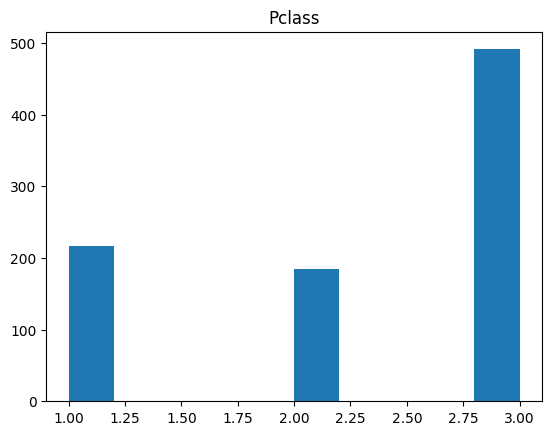

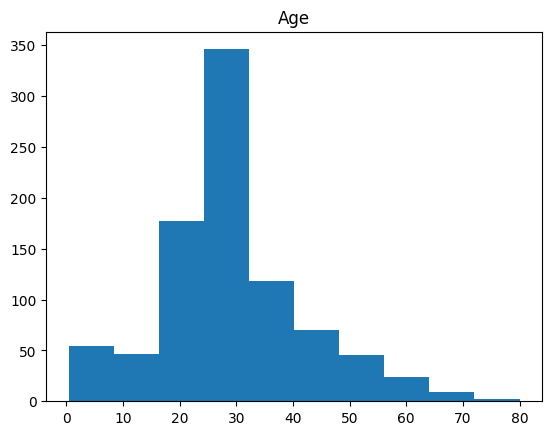

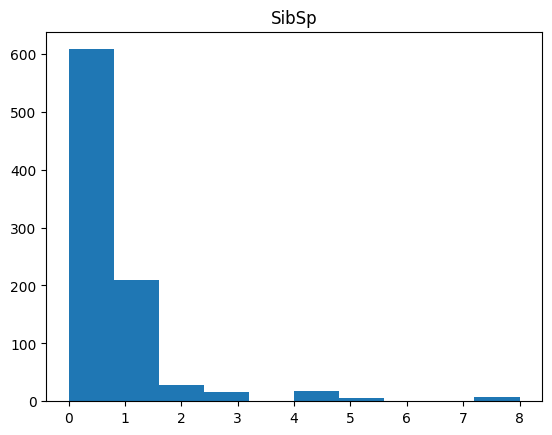

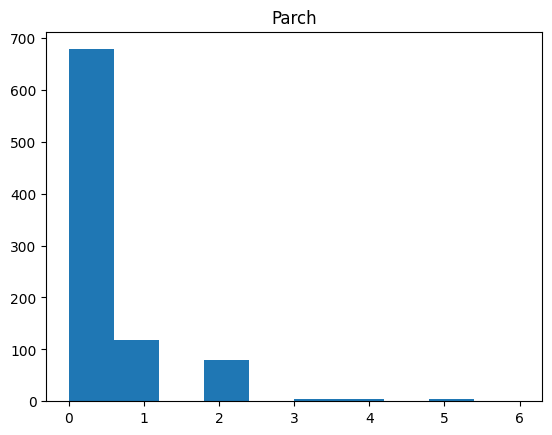

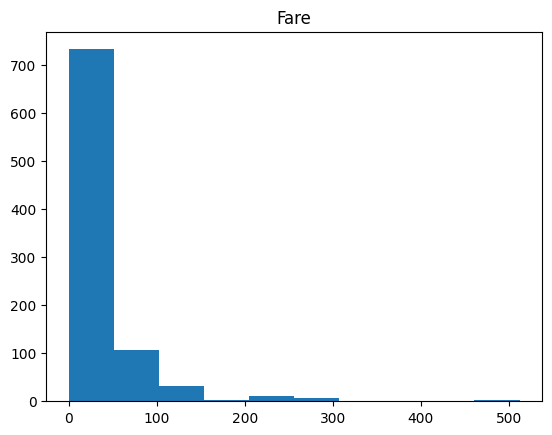

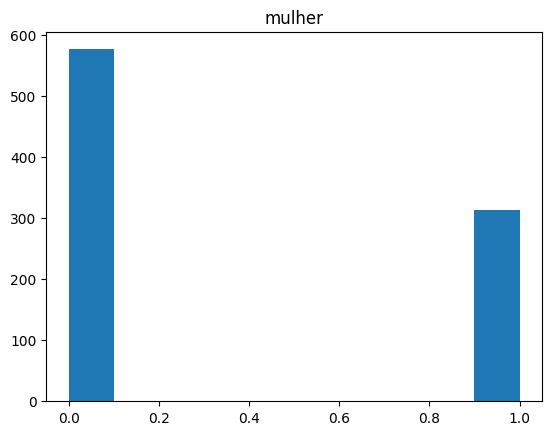

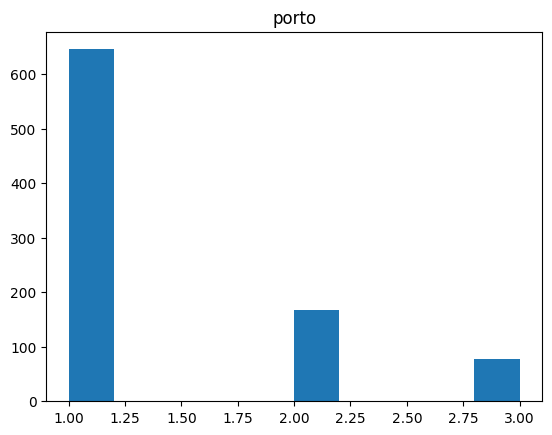

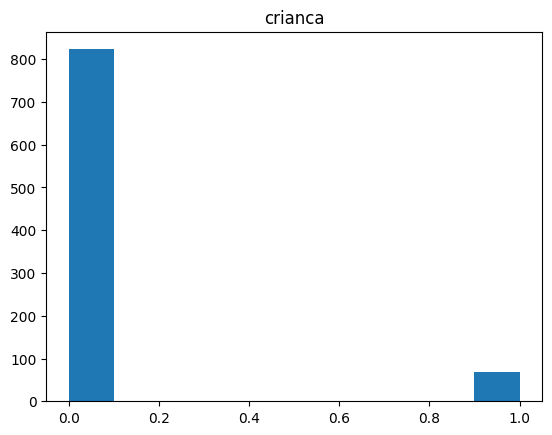

In [14]:
import matplotlib.pyplot as plt

for i in X_train.columns:
    plt.hist(X_train[i])
    plt.title(i)
    plt.show()

## Groupy

In [15]:
train.groupby(['Survived']).count()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Survived,,,,,,,,,,,
0,549,549,549,549,424,549,549,549,549,68,549
1,342,342,342,342,290,342,342,342,342,136,340


## pivot_table

In [16]:
pd.pivot_table(train, index = ['Survived'], columns = ['Pclass'], values = 'PassengerId', aggfunc = 'count')

Pclass,1,2,3
Survived,,,
0,80,97,372
1,136,87,119


## Padronização das features

In [17]:
scaler = StandardScaler() #media 0 e desvio padrão 1

X_train_sc = scaler.fit_transform(X_train)

X_test_sc = scaler.transform(X_test)


## Modelo de validação cruzada

### Logistic Regression

In [18]:
model_lr = LogisticRegression(random_state=0, 
                              n_jobs = -1 )
score =  cross_val_score(model_lr,X_train_sc, y_train, cv = 10, n_jobs = -1)

np.mean(score)

0.8058302122347065

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0759
Function value obtained: -0.8047
Current minimum: -0.8047
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0719
Function value obtained: -0.8047
Current minimum: -0.8047
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0569
Function value obtained: -0.8047
Current minimum: -0.8047
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0760
Function value obtained: -0.8047
Current minimum: -0.8047
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.0746
Function value obtained: -0.8047
Current minimum: -0.8047
Iteration No: 6 started. 

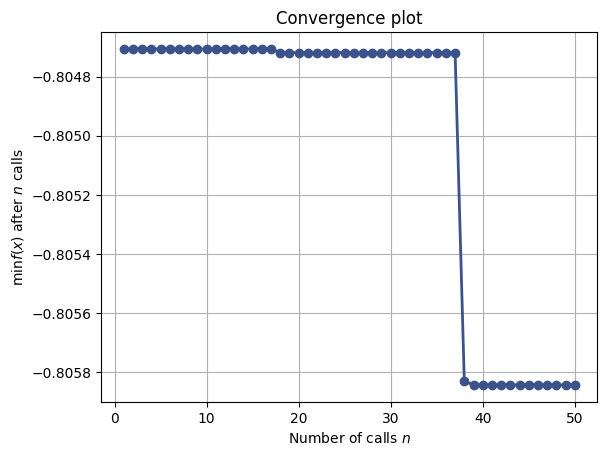

In [19]:
def treinar_modelo_lr(parametros):
    model_lr = LogisticRegression(C=parametros[0], 
                                  solver=parametros[1], 
                                  max_iter=parametros[2], 
                                  random_state=0)
    score = cross_val_score(model_lr, X_train_sc, y_train, cv=10)
    mean_score = np.mean(score)
    return -mean_score

parametros_lr = [(1e-4, 10),                  # C
                 ('liblinear', 'lbfgs'),       # solver
                 (50, 300)]                    # max_iter

otimos_lr = gp_minimize(treinar_modelo_lr, parametros_lr, random_state=0, verbose=1, n_calls=50, n_random_starts=10)
print(otimos_lr.fun, otimos_lr.x)
plot_convergence(otimos_lr)
plt.show()

In [20]:
model_lr = LogisticRegression(C=otimos_lr.x[0], 
                              solver=otimos_lr.x[1], 
                              max_iter=otimos_lr.x[2], 
                              random_state=0)
score = cross_val_score(model_lr, X_train_sc, y_train, cv=10)
np.mean(score)

0.8058426966292135

### Naive Bayes para Classificação

In [21]:
from sklearn.naive_bayes import GaussianNB

model_nb = GaussianNB()

score = cross_val_score(model_nb, X_train_sc, y_train, cv = 10)

np.mean(score)

0.8036079900124845

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0369
Function value obtained: -0.8070
Current minimum: -0.8070
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0309
Function value obtained: -0.8092
Current minimum: -0.8092
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0305
Function value obtained: -0.8081
Current minimum: -0.8092
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0303
Function value obtained: -0.8092
Current minimum: -0.8092
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.0307
Function value obtained: -0.8081
Current minimum: -0.8092
Iteration No: 6 started. 

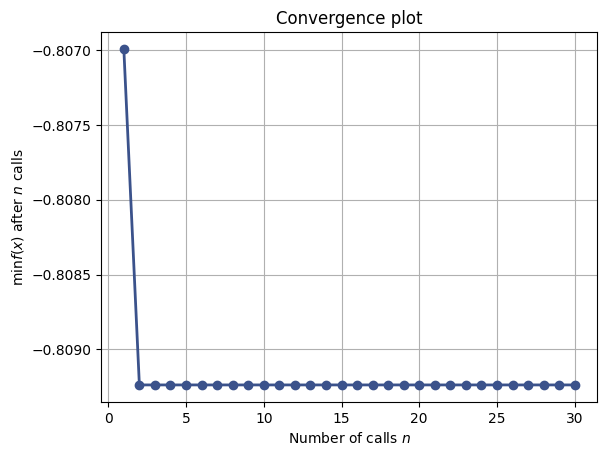

In [22]:
def treinar_modelo_gnb(parametros):
    model_gnb = GaussianNB(var_smoothing=parametros[0])
    score = cross_val_score(model_gnb, X_train_sc, y_train, cv=10)
    mean_score = np.mean(score)
    return -mean_score

parametros_gnb = [(1e-9, 1e-1)]  # var_smoothing

otimos_gnb = gp_minimize(treinar_modelo_gnb, parametros_gnb, random_state=0, verbose=1, n_calls=30, n_random_starts=10)
print(otimos_gnb.fun, otimos_gnb.x)
plot_convergence(otimos_gnb)
plt.show()

In [23]:
model_gnb = GaussianNB(var_smoothing=otimos_gnb.x[0])
score = cross_val_score(model_gnb, X_train_sc, y_train, cv=10)
np.mean(score)

0.8092384519350813

### KNN para classificação

In [24]:
from sklearn.neighbors import KNeighborsClassifier

model_knn = KNeighborsClassifier(n_neighbors= 5, p = 2, n_jobs = -1 )

score = cross_val_score(model_knn, X_train_sc, y_train, cv = 10)

np.mean(score)

0.811498127340824

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.1809
Function value obtained: -0.8025
Current minimum: -0.8025
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.1835
Function value obtained: -0.8036
Current minimum: -0.8036
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.2456
Function value obtained: -0.8204
Current minimum: -0.8204
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.1827
Function value obtained: -0.8059
Current minimum: -0.8204
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.1841
Function value obtained: -0.8047
Current minimum: -0.8204
Iteration No: 6 started. 

/opt/conda/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [30, 'uniform', 2] before, using random point [19, 'uniform', 2]
  warnings.warn(


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.7657
Function value obtained: -0.8070
Current minimum: -0.8227
-0.8226716604244695 [28, 'uniform', 2]


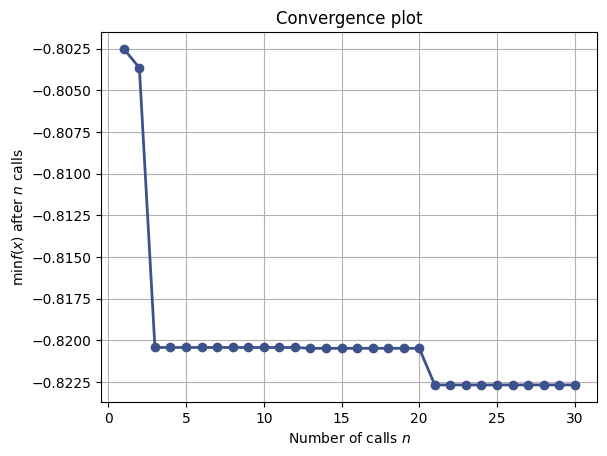

In [25]:
def treinar_modelo_knn(parametros):
    model_knn = KNeighborsClassifier(n_neighbors=parametros[0], 
                                     weights=parametros[1], 
                                     p=parametros[2], 
                                     n_jobs=-1)
    score = cross_val_score(model_knn, X_train_sc, y_train, cv=10)
    mean_score = np.mean(score)
    return -mean_score

parametros_knn = [(1, 30),               # n_neighbors
                  ('uniform', 'distance'), # weights
                  (1, 2)]                 # p (Minkowski metric, 1 for Manhattan, 2 for Euclidean)

otimos_knn = gp_minimize(treinar_modelo_knn, 
                         parametros_knn, 
                         random_state=0, 
                         verbose=1, 
                         n_calls=30, 
                         n_random_starts=10)
print(otimos_knn.fun, otimos_knn.x)
plot_convergence(otimos_knn)
plt.show()

In [26]:
model_knn = KNeighborsClassifier(n_neighbors=otimos_knn.x[0], 
                                 weights=otimos_knn.x[1], 
                                 p=otimos_knn.x[2], 
                                 n_jobs=-1)
score = cross_val_score(model_knn, X_train_sc, y_train, cv=10)
np.mean(score)

0.8226716604244695

### SVM para classificação

In [27]:
from sklearn.svm import SVC

model_svc = SVC(C = 3, 
                kernel = 'rbf', 
                degree = 2, 
                gamma = 0.1)

score = cross_val_score(model_svc, X_train_sc, y_train, cv = 10)

np.mean(score)

0.8316479400749064

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 4.2387
Function value obtained: -0.7902
Current minimum: -0.7902
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.5458
Function value obtained: -0.7924
Current minimum: -0.7924
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.3280
Function value obtained: -0.7867
Current minimum: -0.7924
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.3818
Function value obtained: -0.6162
Current minimum: -0.7924
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.3824
Function value obtained: -0.6162
Current minimum: -0.7924
Iteration No: 6 started. 

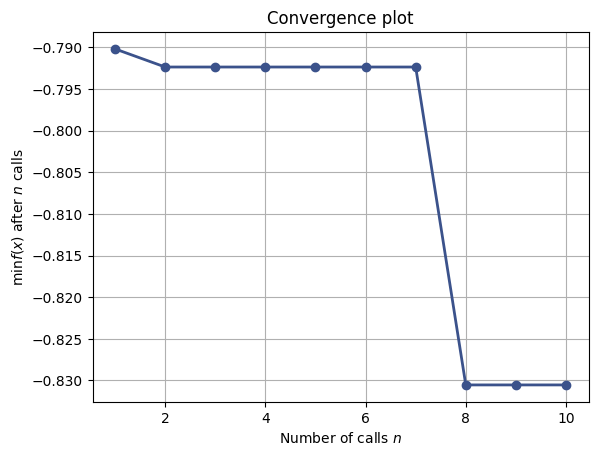

Melhor Acurácia (SVC): 0.8305368289637952
Melhores Hiperparâmetros (SVC): [1.598243724741151, 'rbf', 0.056514086346912004]


In [28]:
# Função de treinamento e avaliação do modelo
def treinar_modelo_svc(parametros):
    model_svc = SVC(
        C=parametros[0], 
        kernel=parametros[1], 
        gamma=parametros[2], 
        probability=True,
        random_state=0
    )
    score = cross_val_score(model_svc, X_train_sc, y_train, cv=10, n_jobs=-1)
    mean_score = np.mean(score)
    return -mean_score

# Espaço de busca para hiperparâmetros
parametros_svc = [
    Real(1e-3, 10, "log-uniform"),            # C em escala log-uniforme
    Categorical(['linear', 'rbf', 'poly']),   # kernel
    Real(1e-6, 1e+1, "log-uniform")           # gamma em escala log-uniforme
]

# Otimização dos hiperparâmetros com gp_minimize
otimos_svc = gp_minimize(
    treinar_modelo_svc, 
    parametros_svc, 
    random_state=0, 
    verbose=1, 
    n_calls=10, 
    n_random_starts=10
)

# Plot da convergência
plot_convergence(otimos_svc)
plt.show()

# Resultados da otimização
print(f"Melhor Acurácia (SVC): {-otimos_svc.fun}")
print(f"Melhores Hiperparâmetros (SVC): {otimos_svc.x}")




In [29]:
model_svc = SVC(C=otimos_svc.x[0], 
                kernel=otimos_svc.x[1], 
                gamma=otimos_svc.x[2], 
                probability=True,
                random_state=0)
score = cross_val_score(model_svc, X_train_sc, y_train, cv=10)
np.mean(score)

0.8305368289637952

### Decision Tree

In [30]:
from sklearn.tree import DecisionTreeClassifier

model_dt = DecisionTreeClassifier(criterion = 'entropy', 
                                  max_depth = 3, 
                                  min_samples_split = 2, 
                                  min_samples_leaf = 1, 
                                  random_state = 0 )

score = cross_val_score(model_dt, X_train_sc, y_train, cv = 10)

np.mean(score)

0.8170536828963796

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0494
Function value obtained: -0.8036
Current minimum: -0.8036
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0479
Function value obtained: -0.8116
Current minimum: -0.8116
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0497
Function value obtained: -0.8228
Current minimum: -0.8228
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0480
Function value obtained: -0.8183
Current minimum: -0.8228
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.0482
Function value obtained: -0.8138
Current minimum: -0.8228
Iteration No: 6 started. 

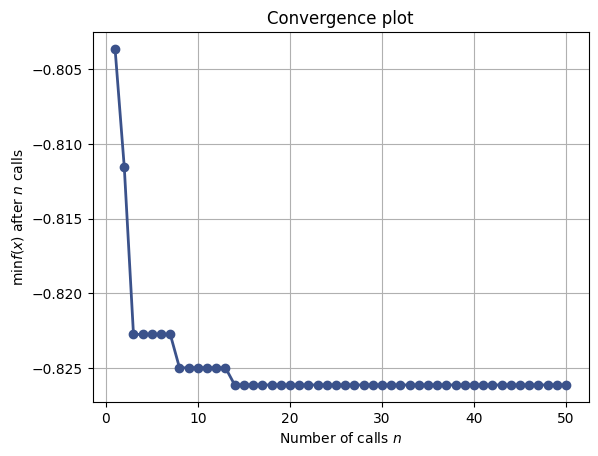

In [31]:
def treinar_modelo_dt(parametros):
    model_dt = DecisionTreeClassifier(criterion=parametros[0], 
                                      max_depth=parametros[1], 
                                      min_samples_split=parametros[2], 
                                      min_samples_leaf=parametros[3], 
                                      random_state=0)
    score = cross_val_score(model_dt, X_train_sc, y_train, cv=10)
    mean_score = np.mean(score)
    return -mean_score

parametros_dt = [('entropy', 'gini'),  # criterion
                 (3, 20),              # max_depth
                 (5, 15),              # min_samples_split
                 (1, 10)]              # min_samples_leaf

otimos_dt = gp_minimize(treinar_modelo_dt, parametros_dt, random_state=0, verbose=1, n_calls=50, n_random_starts=10)
print(otimos_dt.fun, otimos_dt.x)
plot_convergence(otimos_dt)
plt.show()

In [32]:
model_dt = DecisionTreeClassifier(criterion=otimos_dt.x[0], 
                                  max_depth=otimos_dt.x[1], 
                                  min_samples_split=otimos_dt.x[2], 
                                  min_samples_leaf=otimos_dt.x[3], 
                                  random_state=0)
score = cross_val_score(model_dt, X_train_sc, y_train, cv=10)
np.mean(score)

0.8261423220973783

### Random Forest

In [33]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(criterion = 'entropy', 
                                  n_estimators = 100, 
                                  max_depth = 3, 
                                  min_samples_split = 2, 
                                  min_samples_leaf = 1, 
                                  random_state = 0, 
                                  n_jobs = -1 )

score = cross_val_score(model_rf, X_train_sc, y_train, cv = 10)

np.mean(score)

0.8182147315855179

#### Otimização de hiperparametros

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 43.4446
Function value obtained: -0.8250
Current minimum: -0.8250
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 28.1921
Function value obtained: -0.8294
Current minimum: -0.8294
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 33.3567
Function value obtained: -0.8295
Current minimum: -0.8295
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 30.5990
Function value obtained: -0.8216
Current minimum: -0.8295
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 42.2315
Function value obtained: -0.8250
Current minimum: -0.8295
Iteration No: 6 star

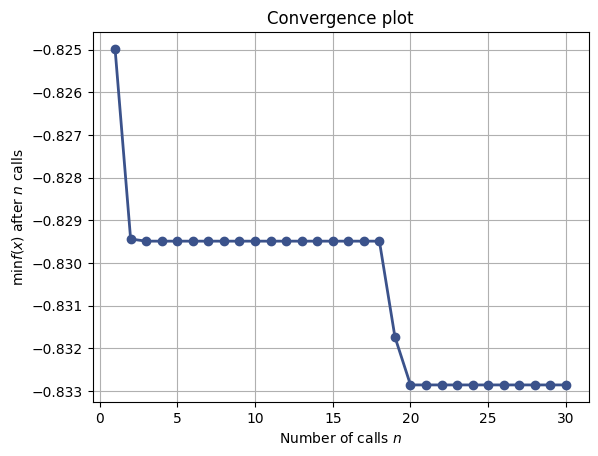

In [34]:
def treinar_modelo(parametros):
    model_rf = RandomForestClassifier(criterion = parametros[0], 
                                      n_estimators = parametros[1], 
                                      max_depth = parametros[2], 
                                      min_samples_split = parametros[3], 
                                      min_samples_leaf = parametros[4], 
                                      random_state = 0, 
                                      n_jobs = -1 )
    score = cross_val_score(model_rf, X_train_sc, y_train, cv = 10)
    mean_score = np.mean(score)
    return - mean_score

parametros = [('entropy', 'gini'), 
              (500, 1200), 
              (3, 20),
              (5, 15),
              (1, 10)]

otimos = gp_minimize(treinar_modelo, 
                     parametros, 
                     random_state = 0, 
                     verbose = 1, 
                     n_calls = 30, 
                     n_random_starts = 10 , 
                     n_jobs = -1 )

print(otimos.fun, otimos.x)
plot_convergence(otimos)
plt.show()

In [35]:
model_rf = RandomForestClassifier(criterion = otimos.x[0], 
                                  n_estimators = otimos.x[1], 
                                  max_depth = otimos.x[2], 
                                  min_samples_split = otimos.x[3], 
                                  min_samples_leaf = otimos.x[4], 
                                  random_state = 0, 
                                  n_jobs = -1 )
score = cross_val_score(model_rf, X_train_sc, y_train, cv = 10)

np.mean(score)

0.8328589263420723

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.6967
Function value obtained: -0.8250
Current minimum: -0.8250
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.2533
Function value obtained: -0.8137
Current minimum: -0.8250
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.4935
Function value obtained: -0.8070
Current minimum: -0.8250
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.8770
Function value obtained: -0.8216
Current minimum: -0.8250
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.2979
Function value obtained: -0.8160
Current minimum: -0.8250
Iteration No: 6 started. 

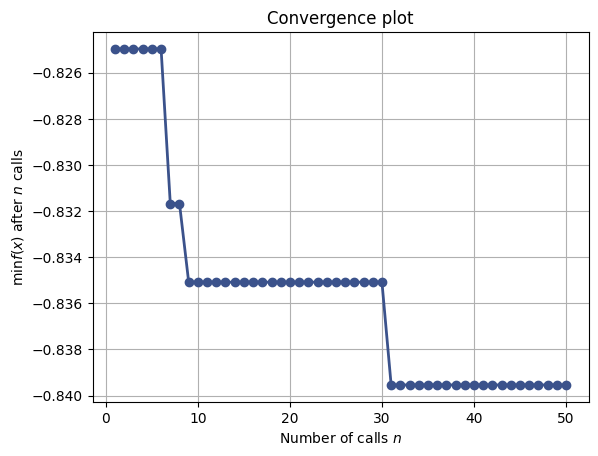

In [43]:
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.plots import plot_convergence
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt

# Função de treinamento e avaliação do modelo
def treinar_modelo_xgb(parametros):
    model_xgb = XGBClassifier(
        n_estimators=parametros[0],
        learning_rate=parametros[1],
        max_depth=parametros[2],
        min_child_weight=parametros[3],
        subsample=parametros[4],
        colsample_bytree=parametros[5],
        gamma=parametros[6],
        random_state=0,
        use_label_encoder=False,
        eval_metric='logloss'
    )
    
    # Validação cruzada para avaliar o modelo
    score = cross_val_score(model_xgb, X_train_sc, y_train, cv=10, n_jobs=-1)
    mean_score = np.mean(score)
    return -mean_score  # Maximizar a acurácia é equivalente a minimizar o negativo da acurácia

# Espaço de busca para hiperparâmetros
parametros = [
    Integer(100, 1200),  # n_estimators
    Real(0.01, 0.3, 'log-uniform'),  # learning_rate
    Integer(3, 10),  # max_depth
    Integer(1, 10),  # min_child_weight
    Real(0.6, 1.0),  # subsample
    Real(0.6, 1.0),  # colsample_bytree
    Real(0, 5)  # gamma
]

# Otimização dos hiperparâmetros com gp_minimize
otimos = gp_minimize(
    treinar_modelo_xgb, 
    parametros, 
    random_state=0, 
    verbose=1, 
    n_calls=50, 
    n_random_starts=10
)

# Resultados da otimização
print(f"Melhor Acurácia: {-otimos.fun}")
print(f"Melhores Hiperparâmetros: {otimos.x}")

# Plot da convergência
plot_convergence(otimos)
plt.show()

In [50]:
model_xgb = XGBClassifier(
    n_estimators=otimos.x[0],
    learning_rate=otimos.x[1],
    max_depth=otimos.x[2],
    min_child_weight=otimos.x[3],
    subsample=otimos.x[4],
    colsample_bytree=otimos.x[5],
    gamma=otimos.x[6],
    random_state=0,
    use_label_encoder=False,
    eval_metric='logloss'
)

score = cross_val_score(model_xgb, X_train_sc, y_train, cv = 10)

np.mean(score)

0.8395380774032459

## Ensanble model (Voting)

In [45]:
from sklearn.ensemble import VotingClassifier

# Configurando o ensemble VotingClassifier
model_voting = VotingClassifier(
    estimators=[
#         ('LR', model_lr), 
#         ('NB', model_nb), 
#         ('KNN', model_knn), 
        ('SVC', model_svc), 
        ('RF', model_rf),
        ('XGB', model_xgb)
    ],
    voting='soft'  # Use 'soft' para ponderação de probabilidades
)

# Treinando o ensemble VotingClassifier
model_voting.fit(X_train_sc, y_train)

# Avaliação do ensemble com validação cruzada
score = cross_val_score(model_voting, X_train_sc, y_train, cv=10, n_jobs=-1)  # Aqui n_jobs está correto
print(f"Acurácia do Ensemble Voting: {np.mean(score)}")


Acurácia do Ensemble Voting: 0.8384019975031212


## Modelo Final

In [46]:
model_voting.fit(X_train_sc, y_train)

y_pred = model_voting.predict(X_train_sc)

confusion_matrix(y_train, y_pred)

array([[515,  34],
       [ 95, 247]])

In [47]:
score = model_voting.score(X_train_sc, y_train)
score

0.8552188552188552

## Predição dos dados de teste

In [48]:
y_pred_test = model_voting.predict(X_test_sc)

submission = pd.DataFrame(test['PassengerId'])

submission['Survived'] = y_pred_test

submission.to_csv('submission.csv', index= False)

In [49]:
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
